# XGBoost model
eXtreme Gradient Boosting ([XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md)) is an implementation of gradient boosted decision trees designed for speed and performance.
This notebook implements the final model of XGBoost used in our analysis.
Since it was not easy to integrate our custom evaluation function (BIP_error), we tried to minimize many built-in evaluation metrics of the XGBoost library (mae, rmse..), and then used the one that produced the best results in term of BIP_error, which in this case was rmse.

#### Feature selection
The feature selection was performed both by using the feature_selection library of SciKitLearn and by increasingly excluding the least important features that were detected by the model and plot after the training of the model

#### Hyperparameters Tuning
The tuning of the Hyperparameters for XGBoost was done using the RandomizedSearchCV method and using SciKitLearn wrapper of XGBoost (XGBRegressor) with a 5-fold cross-validation on 30% of the train test and providing it the parameters: gamma, learning_rate, max_depth, reg_alpha onto which apply the Grid Search. The best parameters it found were: {'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}, however, testing the parameters with our train-test split policy did not produce better results than the parameters found by manually try some combinations, thus, in the end we modified them.

#### Train-test split
Initially we split train and test sets with the train_test_split in model_selection of SciKitLearn, the results were too optimistic and then we decided to split in a way that would result in having a test set similar to the one we were going to be evaluated on, so we selected some test sets a pair of months in the 24 months of the train, in particular we concentrated on the pairs that seemed more significant in our analysis based on the real test we would have had to predict in the end which are:
* January and February 2018
* March and April 2017
* March and April 2016

The first one because it is the last 2 months we have and in a way this captures the real test set we have to predict, the other two were chosen because the real test set is for March and April.



In [1]:
# reoder variables to work on train or test dataset
predict_for_submission = True
predict_for_submission = False

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline

from RMSE import rmspe,rmspe_xg
import modify_dataset as md

In [7]:
df = pd.read_csv('./dataset/preprocessed_train_PCA.csv')

if predict_for_submission:
    df_test = pd.read_csv('dataset/preprocessed_test_PCA.csv')

In [8]:
df = df.drop(['NumberOfCustomers'], axis=1)
#OHE attr.
df = df.drop(['StoreType','AssortmentType'], axis=1)
#only for pca dataset
df = df.drop(['Unnamed: 0'], axis=1)

In [9]:
if predict_for_submission:
    train = df
    test = df_test
else:
    test_months = (3, 4)
    test_year = 2017

    train = md.get_fake_train(df, test_months, test_year)
    test = md.get_fake_test(df, test_months, test_year)

print('df.shape    ', df.shape)
print('train.shape ', train.shape)
print('test.shape  ', test.shape)

df.shape     (433958, 41)
train.shape  (396420, 41)
test.shape   (37538, 41)


### Selecting predictive features 

In [10]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('Date')
features.remove('MeanRegionCustomers')
features.remove('D_DayOfweek')

#features.remove('p11')
#features.remove('p12')
#features.remove('p7')
#features.remove('p9')
#4.5%

#features.remove('p8')
#features.remove('p10')
#4.2%
print("features:")

pprint(features)
print(len(features))

features:
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'MeanCustomers',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12']
36


### SciKitLearn feature selection

In [11]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


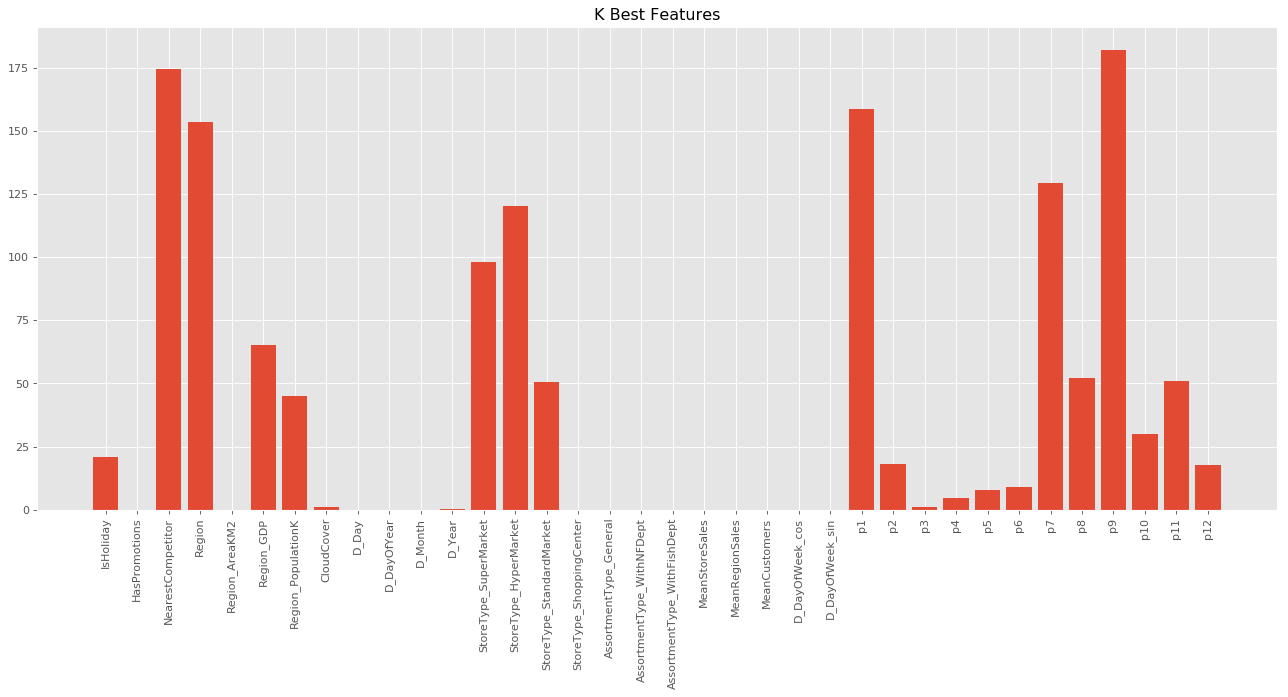

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# Perform feature selection
selector = SelectKBest(f_regression, k=20)
selector.fit(train[features], train['NumberOfSales'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores for each feature 
plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.title('K Best Features')
plt.show()

## Hyperparameters tuning (it takes a lot of time)

In [13]:
#from xgboost.sklearn import XGBRegressor # wrapper
## XGB with sklearn wrapper
## the same parameters as for xgboost model
#params_sk = {'max_depth': 8, 
#            'n_estimators': 100, # the same as num_rounds in xgboost
#            'objective': 'reg:linear', 
#            'subsample': 1.0, 
#            'colsample_bytree': 0.3, 
#            'learning_rate': 0.1, 
#            'seed': 23}     
#
#skrg = XGBRegressor(**params_sk)
#
#skrg.fit(X_train[features], np.log(X_train["NumberOfSales"] + 1))

In [14]:
#import scipy.stats as st
#
#params_grid = {  
#    'learning_rate': st.uniform(0.001, 0.2),
#    'max_depth': list(range(6, 20, 2)),
#    'gamma': st.uniform(0, 40),
#    'reg_alpha': st.expon(0, 40)}
#
#search_sk = RandomizedSearchCV(skrg, params_grid, cv = 3, verbose=2) # 3 fold cross validation
#search_sk.fit(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#
## best parameters
#print(search_sk.best_params_); print(search_sk.best_score_)

### Hyperparameters tuning result
The result was obtained using 0.3 of the train set (22 months) at random.
#### Result
{'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}
0.8171277539145538

DMatrix of train and test, NumberOfSales transformes to log + 1 to improve prediction result

In [15]:
dtrain = xgb.DMatrix(train[features], np.log(train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(test[features], np.log(test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [16]:
#Using tuned params
params = {"objective": "reg:linear",
          "eta": 0.2,   #0.17
          "max_depth": 10,
          "subsample": 0.8,  #0.8
          "colsample_bytree": 0.3, #0.3 #0.2
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          "gamma": 0.5, #2
          #"seed": 23,
          #"reg_alpha": 2  #4
          #"gamma": 14.5573974470,  #added as a test
          "reg_alpha": 1
          }

#reg_alpha 
#reg_lambda
num_trees = 100 #400

In [17]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.30279	train-rmse:6.33837
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.04539	train-rmse:5.07614
[2]	test-rmse:4.03475	train-rmse:4.06428
[3]	test-rmse:3.23158	train-rmse:3.25692
[4]	test-rmse:2.58838	train-rmse:2.60957
[5]	test-rmse:2.07458	train-rmse:2.09501
[6]	test-rmse:1.66922	train-rmse:1.68494
[7]	test-rmse:1.33964	train-rmse:1.35428
[8]	test-rmse:1.08119	train-rmse:1.09521
[9]	test-rmse:0.8744	train-rmse:0.885014
[10]	test-rmse:0.712262	train-rmse:0.716691
[11]	test-rmse:0.58824	train-rmse:0.587915
[12]	test-rmse:0.485909	train-rmse:0.483256
[13]	test-rmse:0.414206	train-rmse:0.40278
[14]	test-rmse:0.358017	train-rmse:0.342391
[15]	test-rmse:0.311846	train-rmse:0.291392
[16]	test-rmse:0.278206	train-rmse:0.253256
[17]	test-rmse:0.254121	train-rmse:0.22603
[18]	test-rmse:0.237285	train-rmse:0.206901
[19]	test-rmse:0.226635	train-rmse:0.193556
[20]	tes

### Plotting Trees

In [18]:
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (15, 6)
#plt.rcParams['figure.figsize'] = [40.0,20.0]
#plt.rcParams['figure.dpi']=400
#plt.rcParams.update({'font.size': 30})

In [19]:
from xgboost import plot_tree


In [20]:
#xgb.to_graphviz(gbm, num_trees=1, rankdir='LR', **{'size':str(20)})

### Validating

In [21]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, test['NumberOfSales'].values)
print('error', error)

Validating
error 0.19831768554290408


RMSE

## Feature importance analysis:

In [22]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [30.0,16.0]
plt.rcParams['figure.dpi']=200
plt.rcParams.update({'font.size': 24})

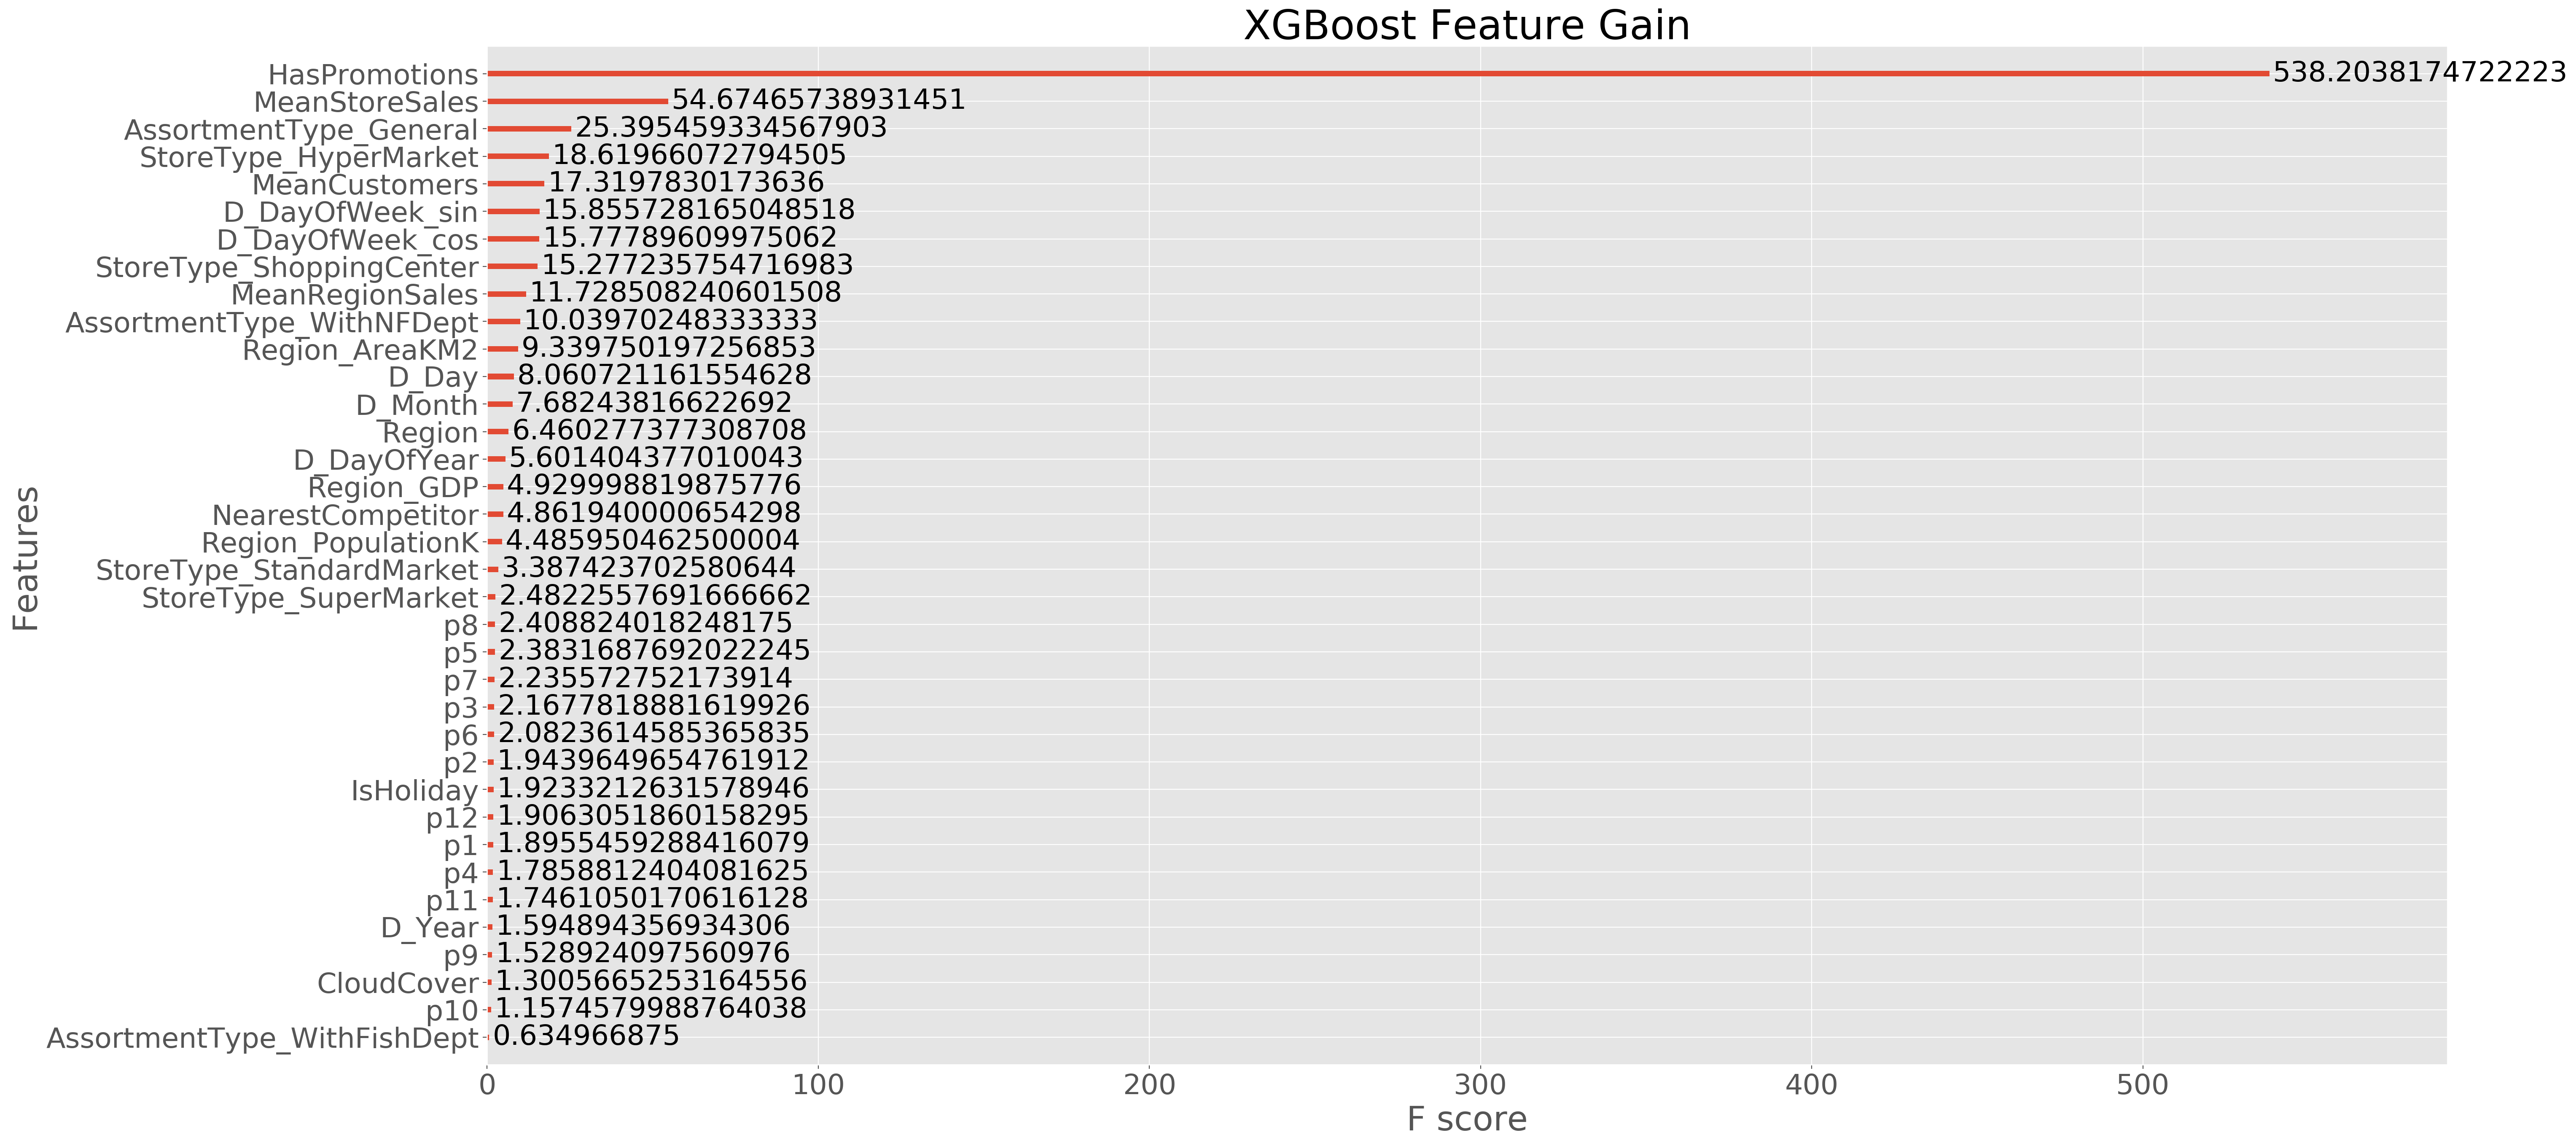

In [23]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

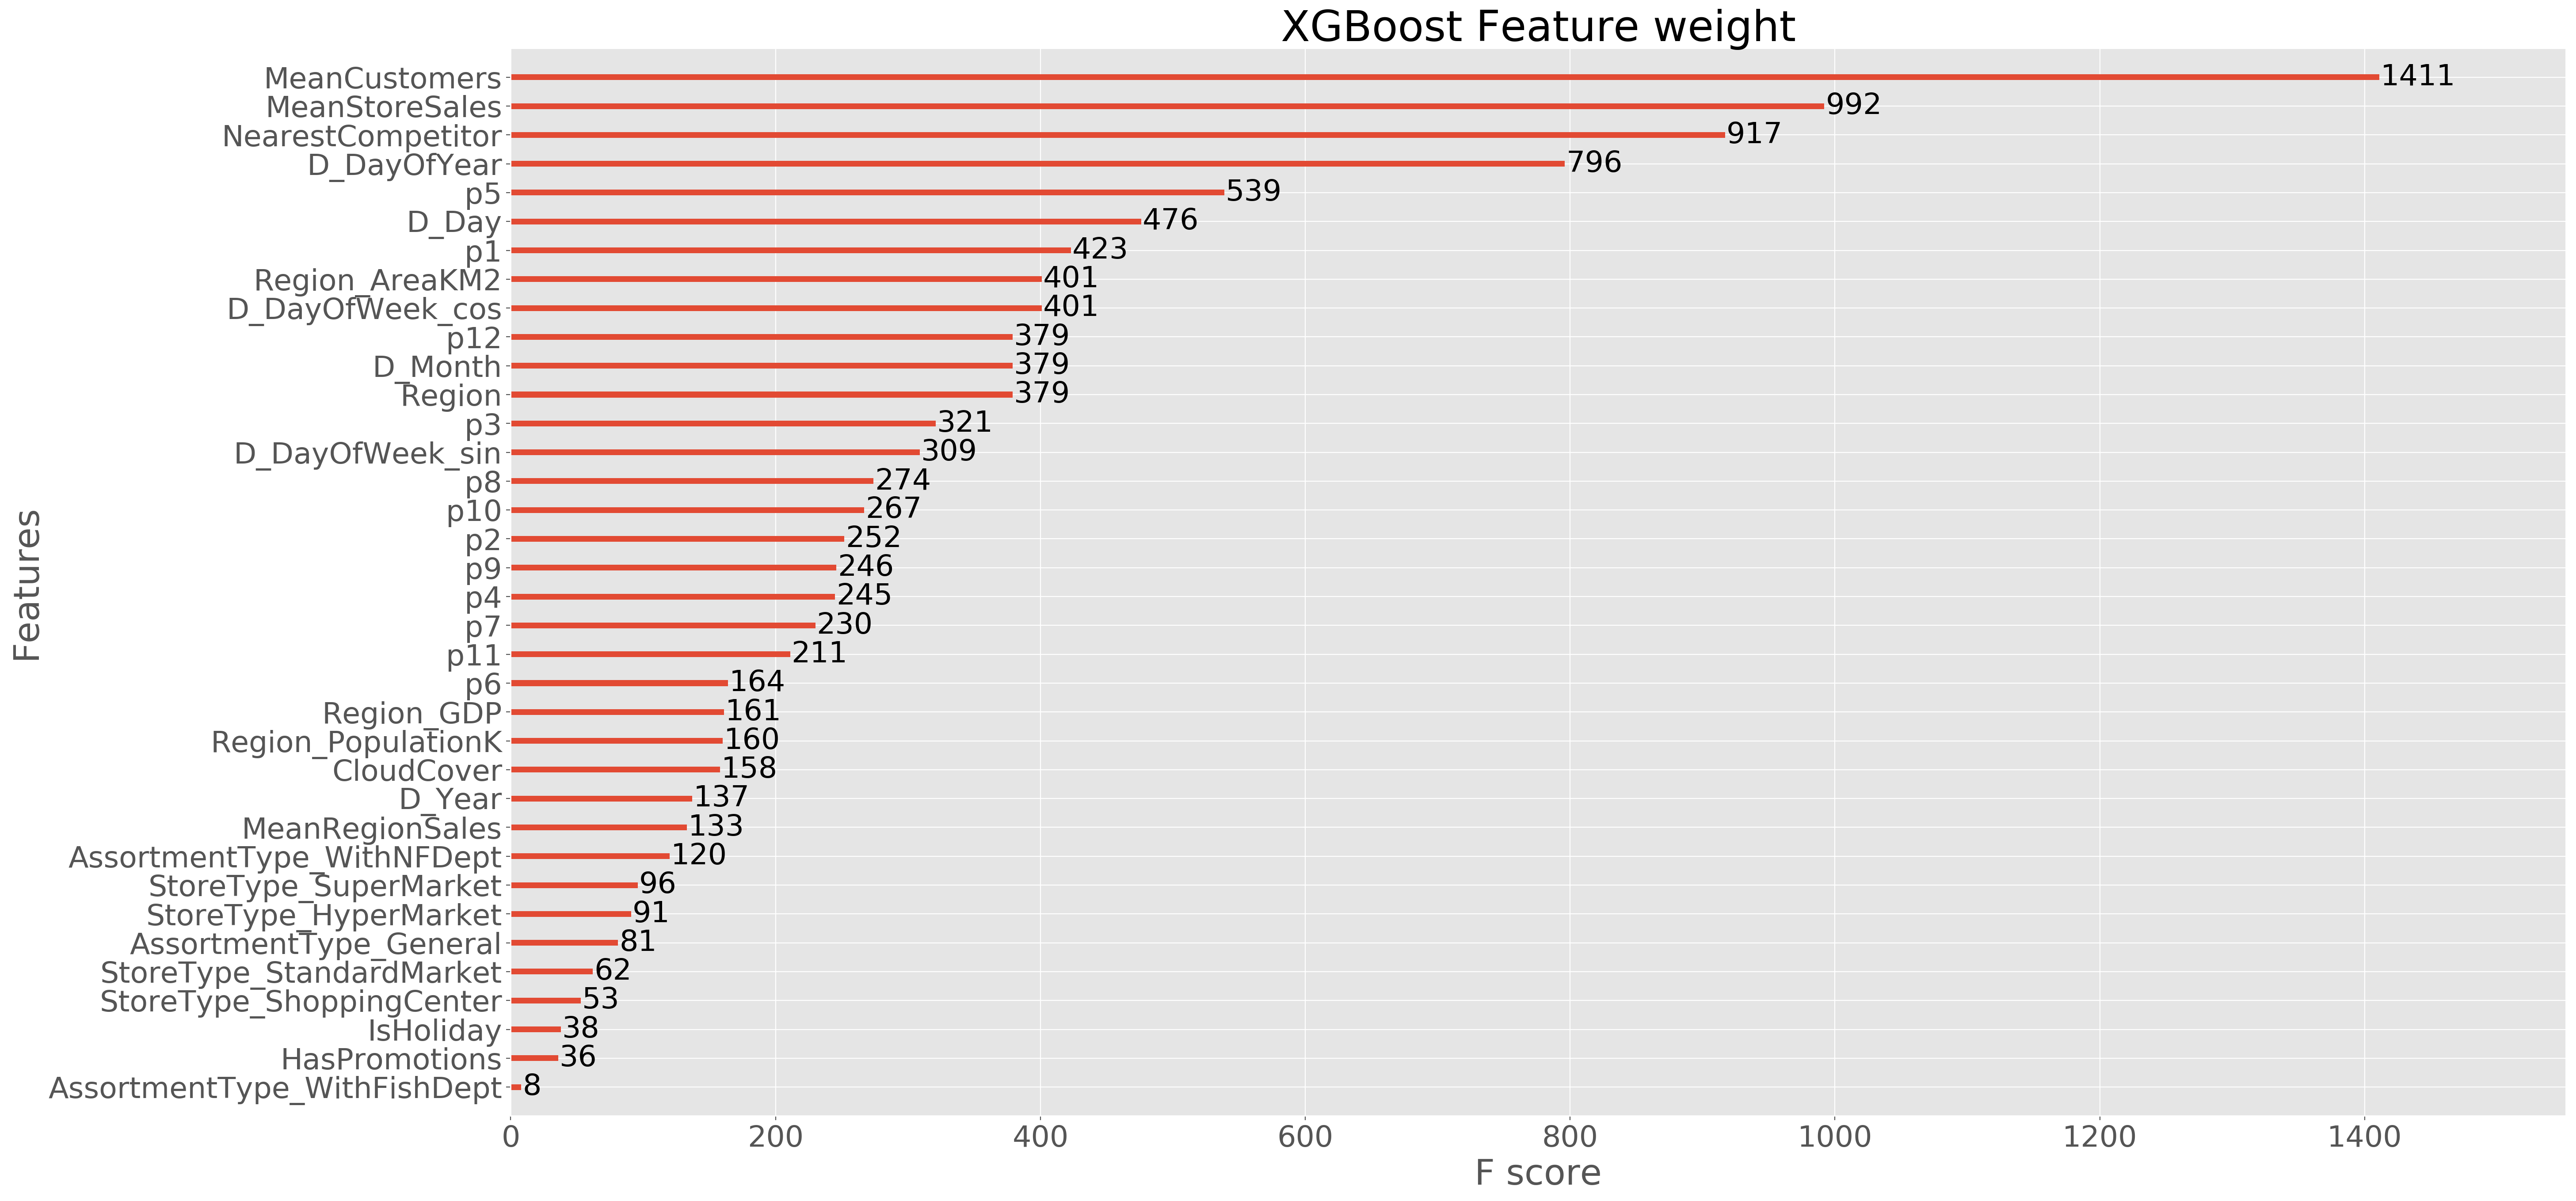

In [24]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

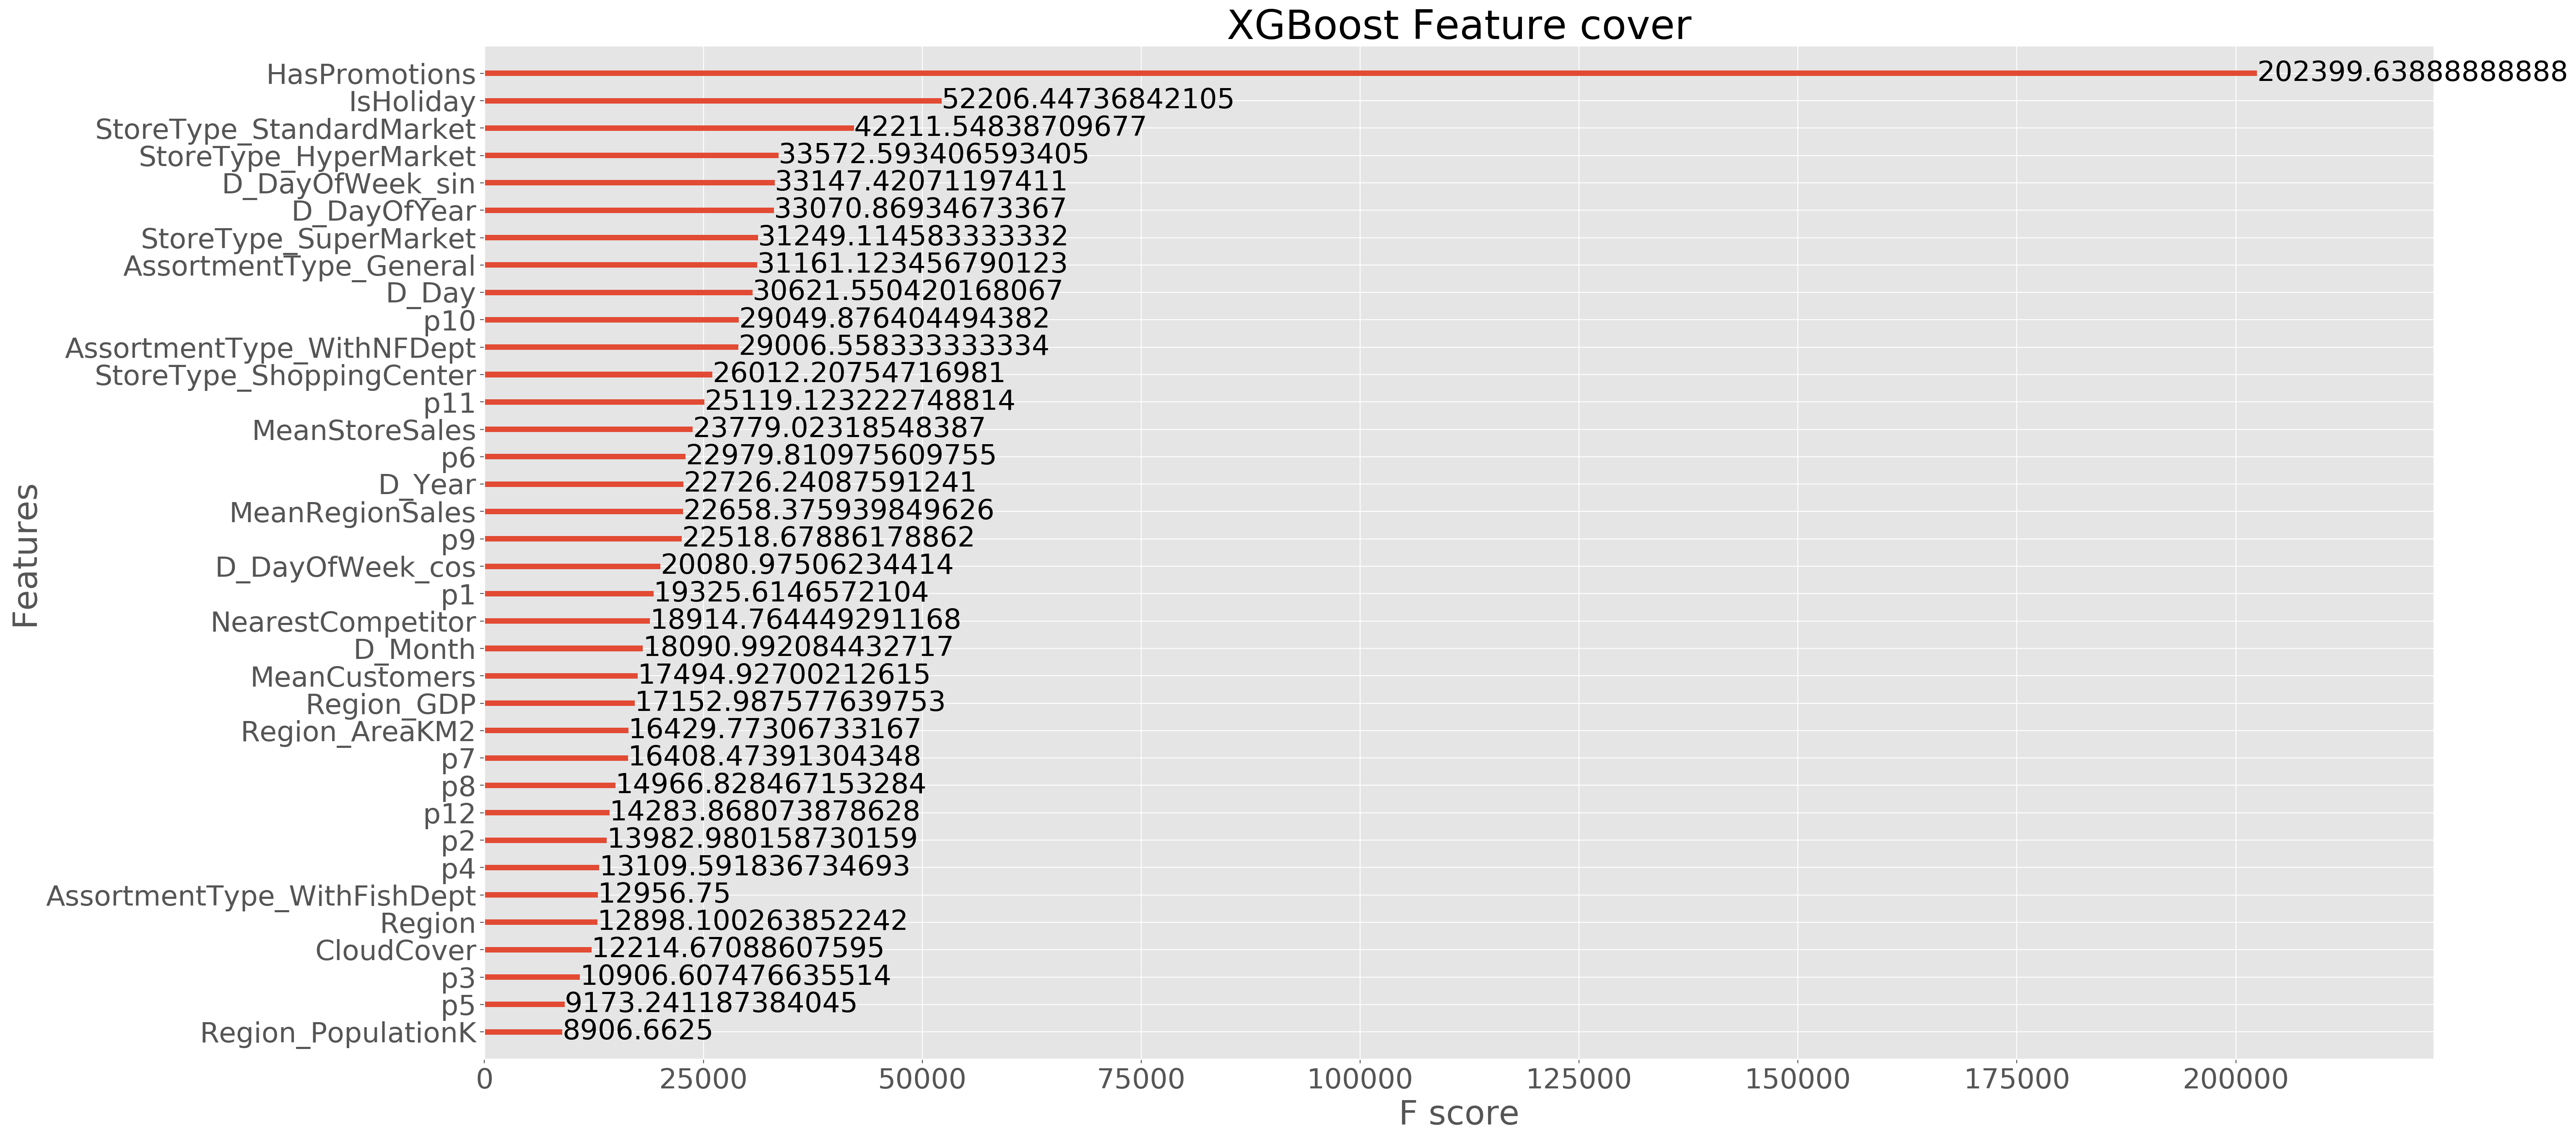

In [25]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [26]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [35]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1
train['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(train[features])))-1

/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## BIP Error

In [36]:
from BIP import get_BIP_error
print('ON TRAIN')
error = get_BIP_error(train)
print('\n')

if not predict_for_submission:
    print('ON TEST')
    error1 = get_BIP_error(test)

ON TRAIN
BIP total error: 0.025362575341655837
ON TEST
BIP total error: 0.06407915313099975


### Writing to file

In [30]:
if predict_for_submission:
    test.to_csv('./dataset/submission_test_m34_RFR_on_prep.csv', index=False)
else:
    mm = 'm{}{}'.format(test_months[0],test_months[1])
    test.to_csv('./dataset/test_'+mm+'_64_Model_XGBoost_final.csv', index=False)

## Comparing predicted and real
Plotting a sample of predicted and real rows to understand if the prediction is accurate

In [31]:
compare = test[['NumberOfSales','_NumberOfSales']]

In [32]:
compare[1000:1020]

NumberOfSales  _NumberOfSales
11988           5246     5843.319336
11989           6530     6402.474121
11990           5843     5899.102051
11991           3366     4439.822266
11992           3757     4040.151855
11993           3816     4451.038574
11994           3640     4577.404297
11995           4148     5057.246582
11996           7387     5226.484863
11997           7058     7117.171387
11998           5830     6133.310547
11999           5641     5838.912109
12000           4645     5721.519531
12001           6164     6158.312500
12002           6341     5575.853027
12003           4102     4866.768066
12004           3712     4641.832520
12005           3438     4665.991211
12006           3959     4934.901367
12007           4628     5578.449219

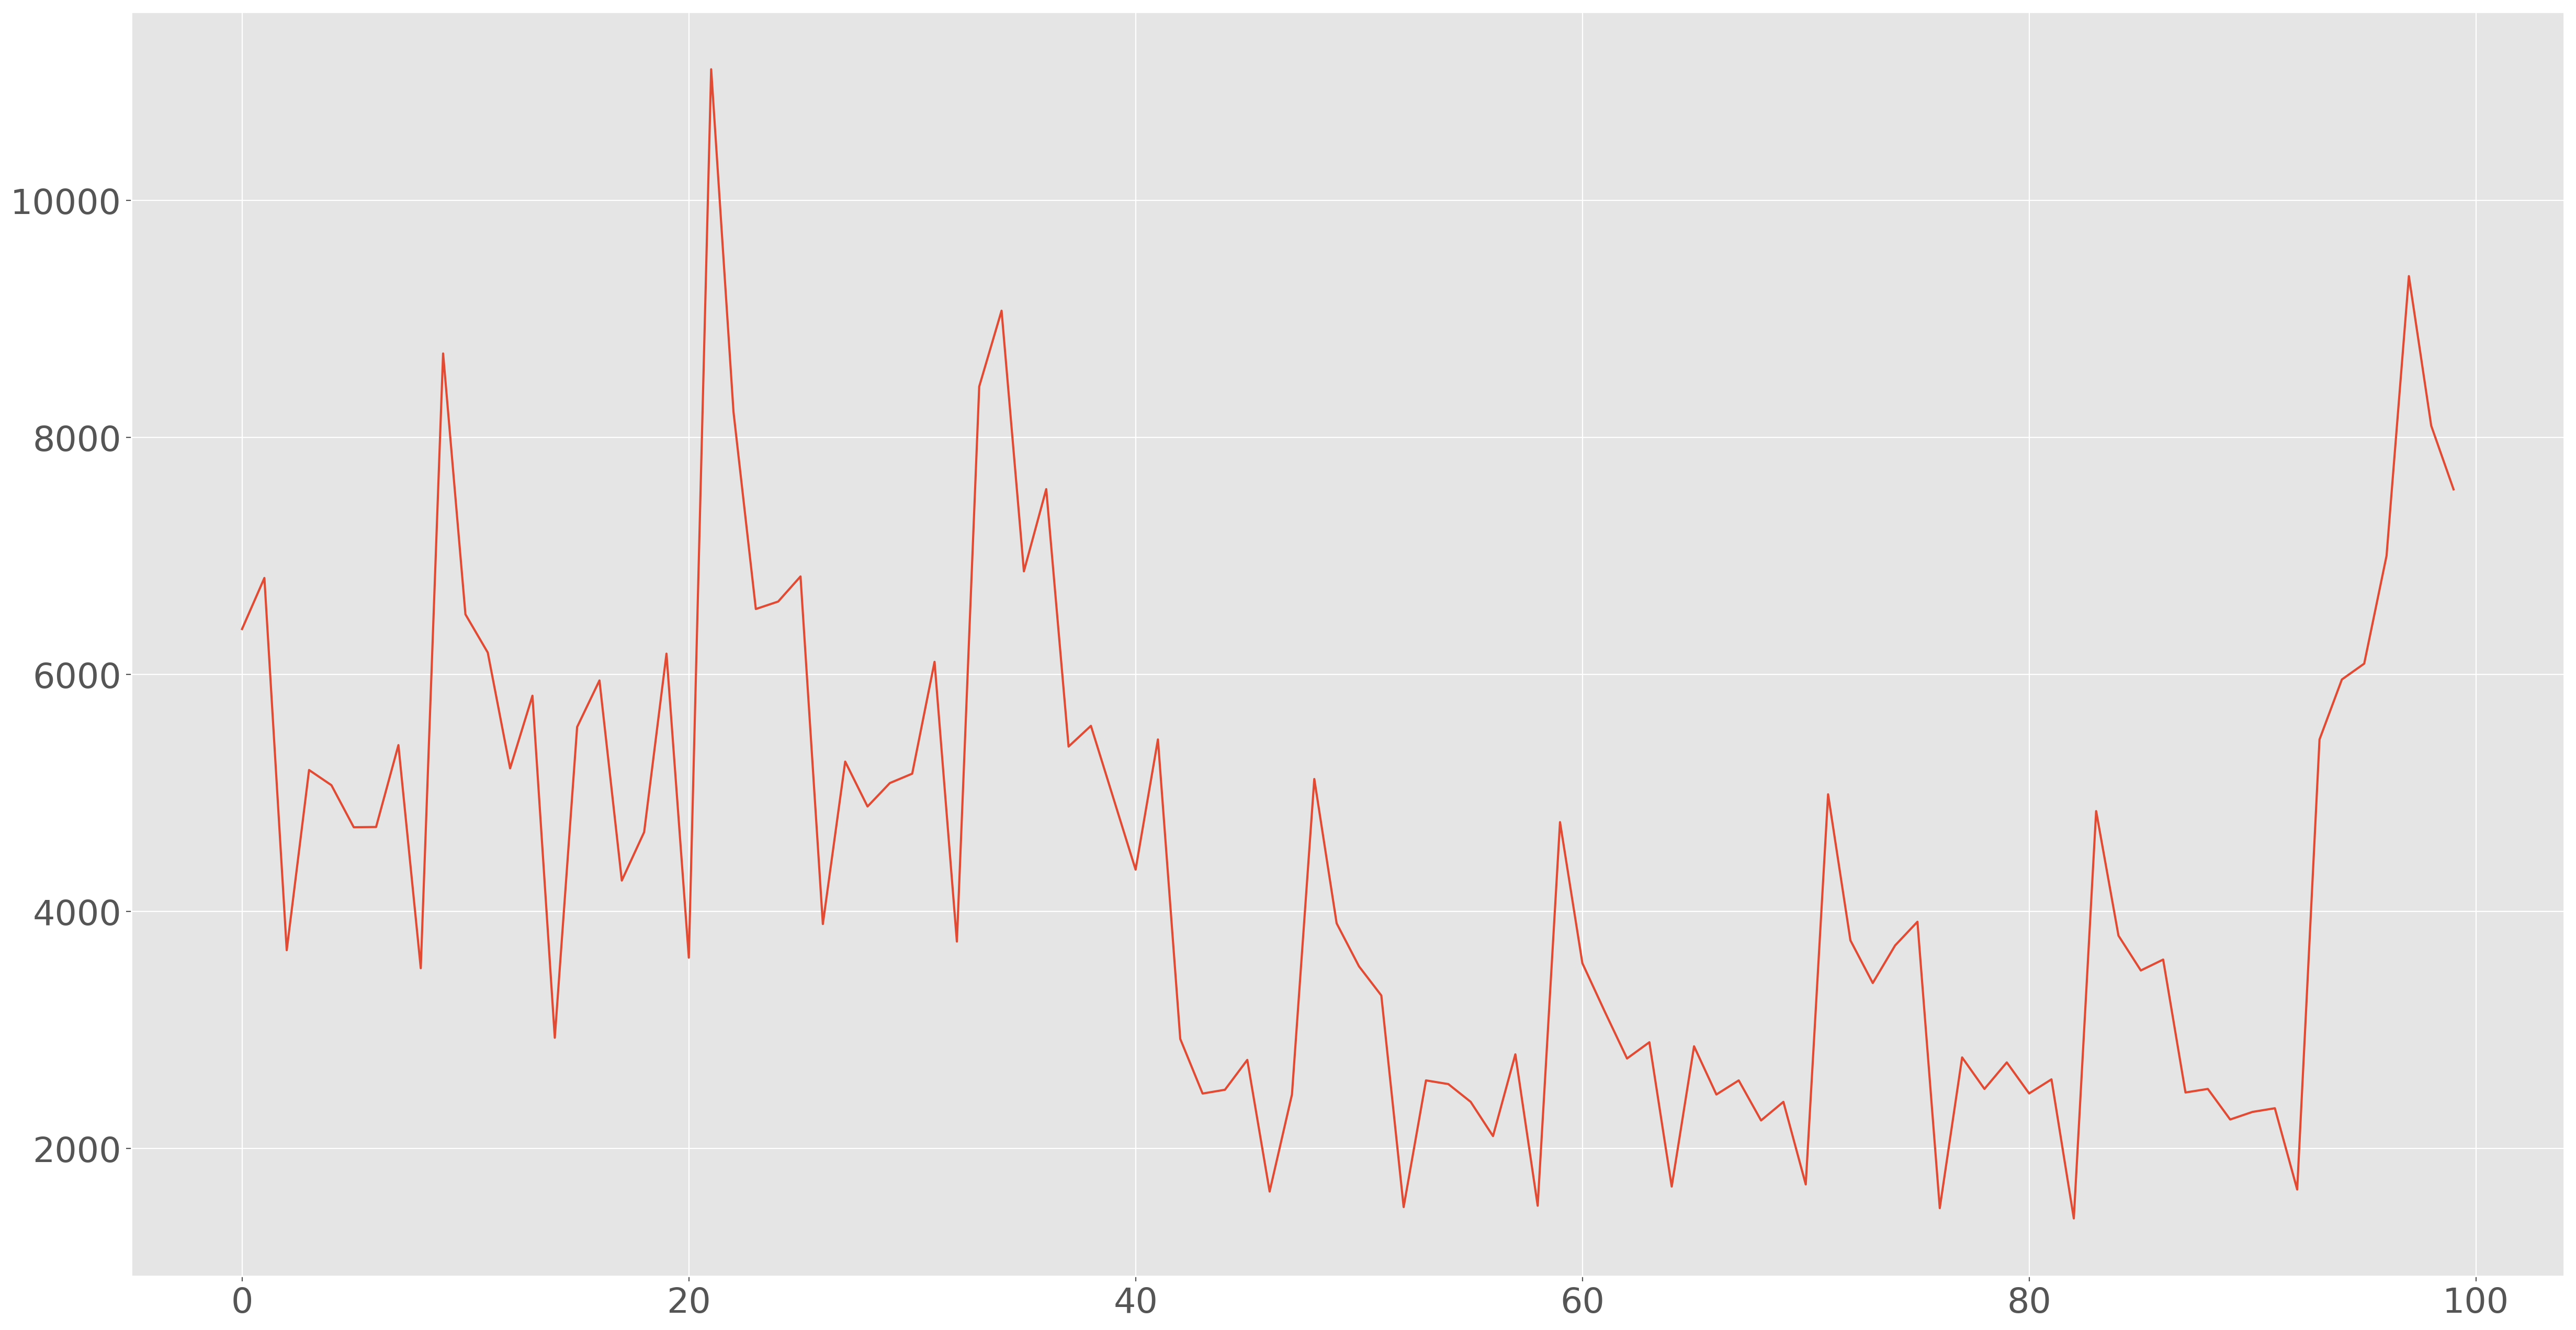

In [33]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

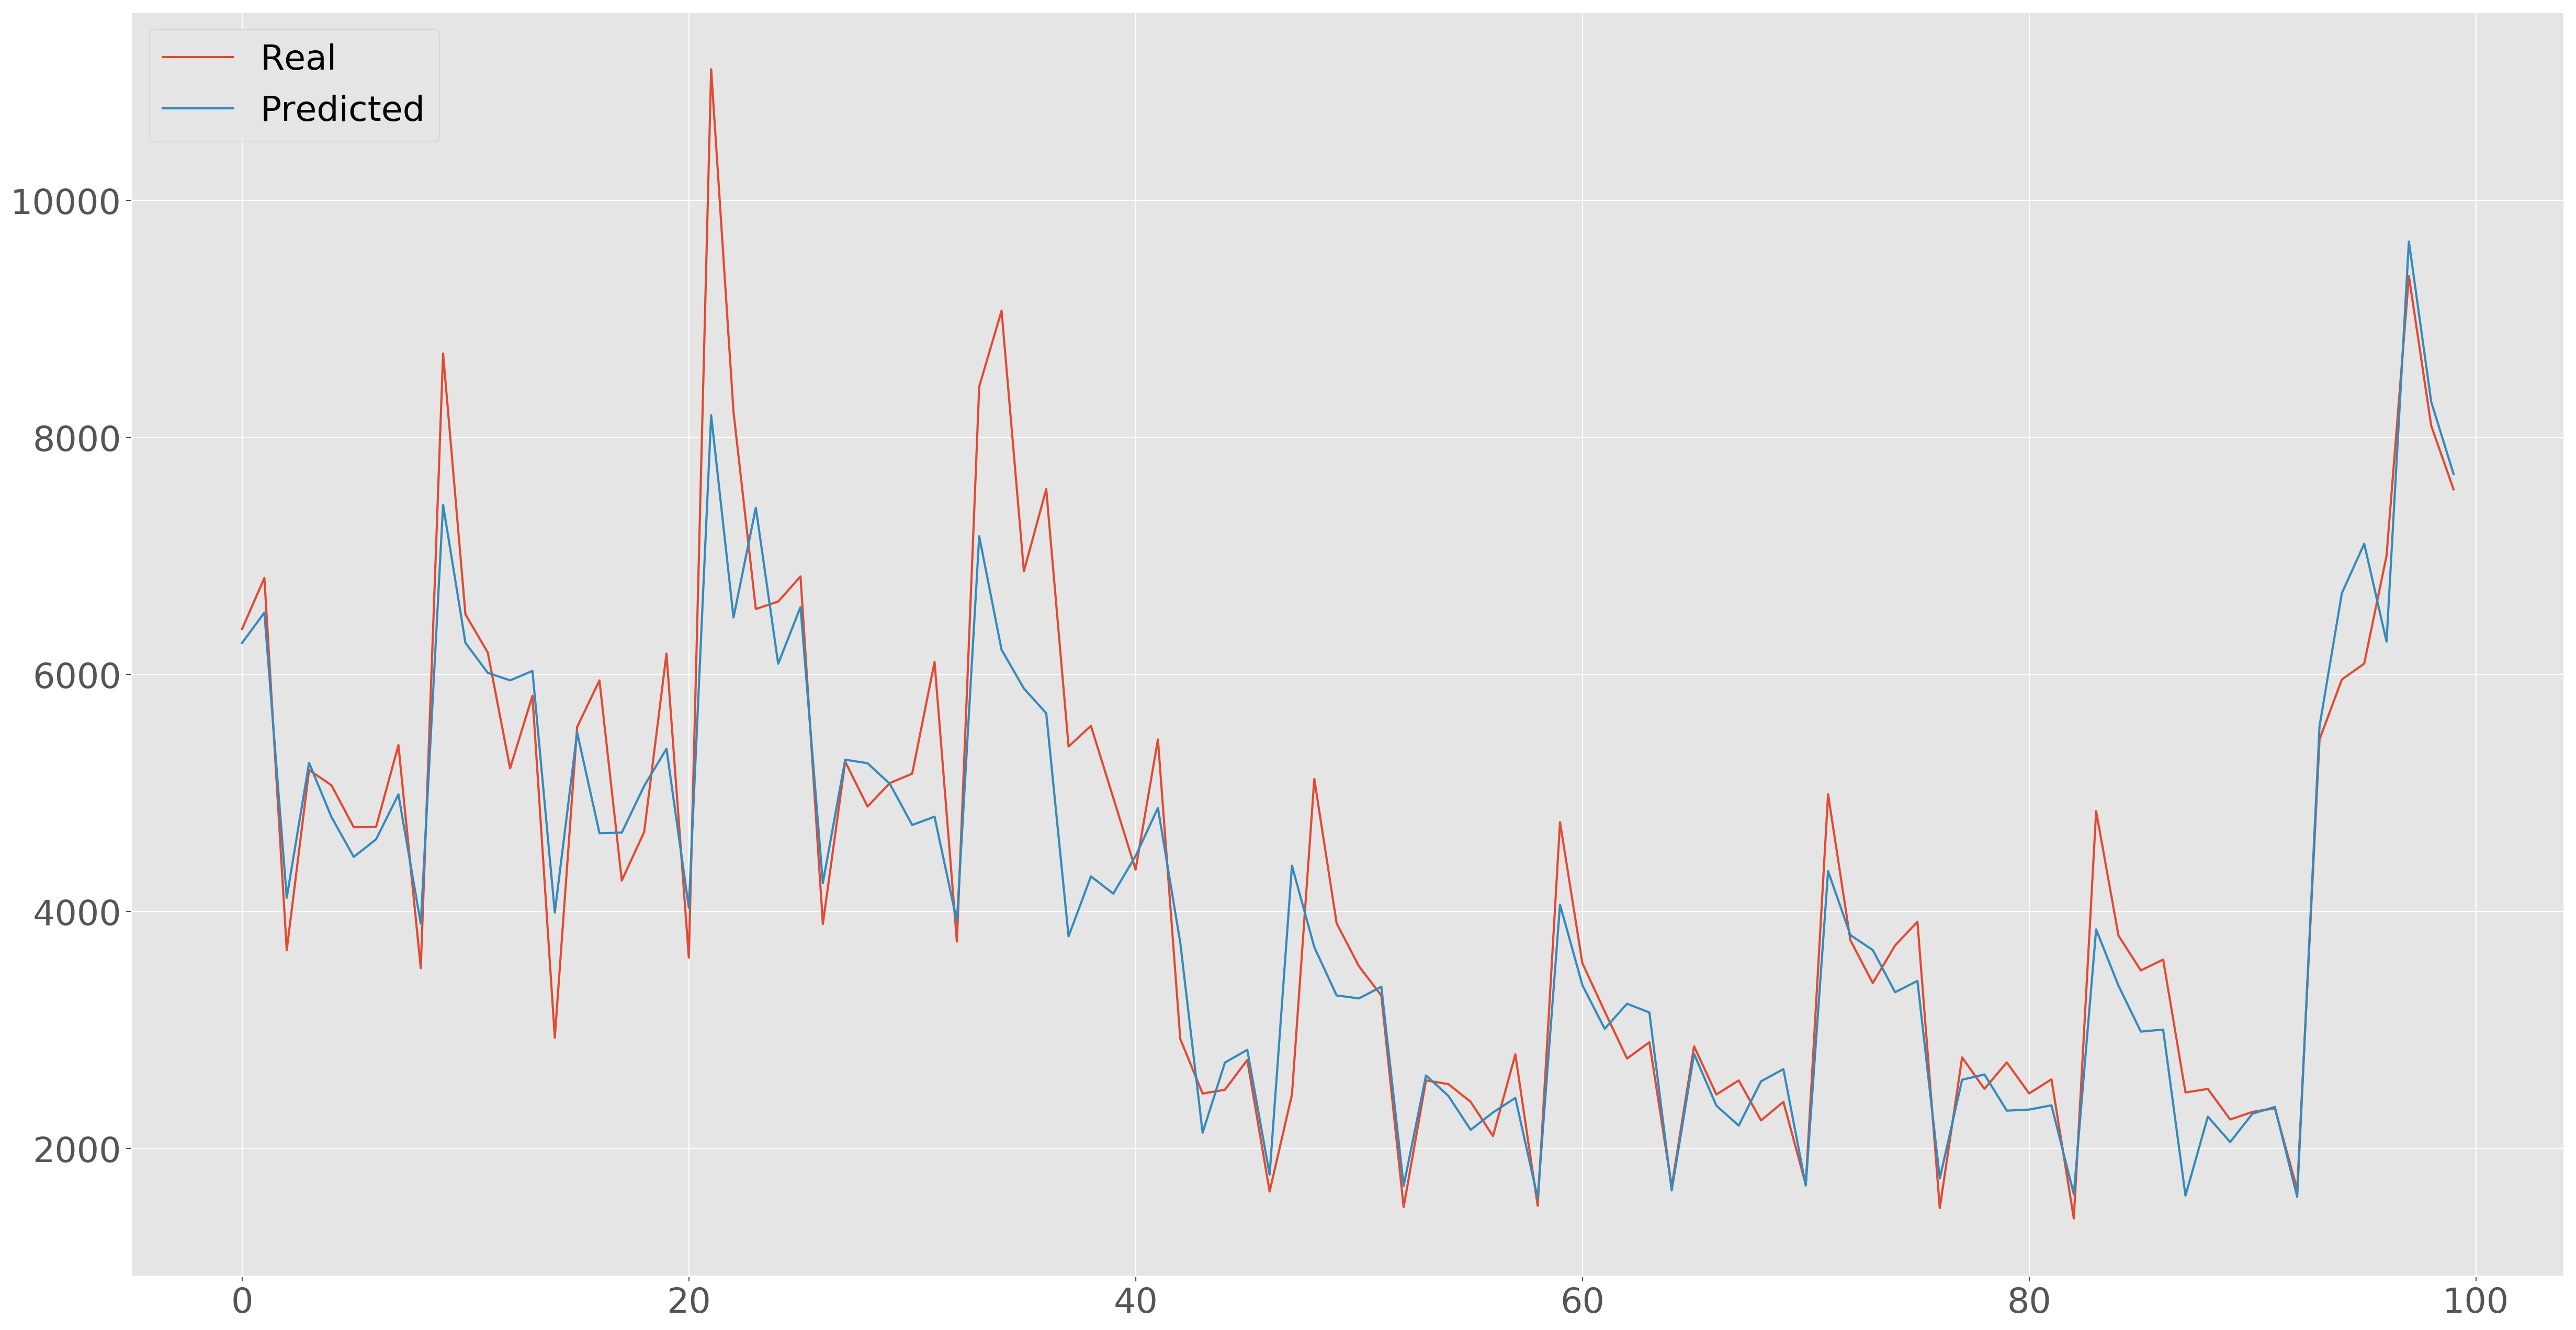

In [34]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

We can notice that the real results has more variance with respect to the predicted ones, this is probably due to the fact that we introduced an important attribute which is the mean sales of a store, this squeezes everything and makes the prediction fall in a small range around the average sales per day, but this is what we want since we don't want to minimize a function that takes into account errors on single days but it looks at the monthly sales.